[Задание](https://d3c33hcgiwev3.cloudfront.net/_241f17ef513f517fb19931139a6be20a_final-statement.html?Expires=1630108800&Signature=NA3mjOL9SU4CyDhHcvluNbQUrZTNIuuoqYhniOSg-9fXdrCJjRlSYTQl0D0EMGo0KJWED3ZwD2KVvNjQ-euzTs8pitQBVa6Rj1ak-n9uGNa3-wqyPii-5t84Go-JP0FcaWZKoTwxNKVn~iI60yIuv5f1Mlk4MddDZvSB-z0OAN4_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)

[Kaggle](https://www.kaggle.com/c/dota-2-win-probability-prediction/overview)

# Packages

In [ ]:
import json
import bz2
import pandas as pd
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.core.frame import DataFrame

In [ ]:
# некоторые константы
# N_SPLITS = 5
# N_TREES_MAX = 50
# CV_R2_MIN = 0.525
RANDOM_STATE = 241

# Data

In [ ]:
drive_path = '/content/drive/MyDrive/coursera_ml_final'

In [ ]:
matches = []
cnt = 0
with bz2.BZ2File(drive_path + '/data/matches.jsonlines.bz2') as matches_file:
    for line in matches_file:
        matches.append(json.loads(line))
        cnt += 1
        if cnt > 3:
            break
        # match = json.loads(line)
        # Обработка матча
        # break
print(cnt)

4


In [ ]:
features = pd.read_csv(drive_path + '/features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


In [ ]:
for i in range(len(features.columns)):
    print(features.columns[i], end=" " if i%10 > 0 else "\n")
# radiant_win - dependent variable

start_time
lobby_type r1_hero r1_level r1_xp r1_gold r1_lh r1_kills r1_deaths r1_items r2_hero
r2_level r2_xp r2_gold r2_lh r2_kills r2_deaths r2_items r3_hero r3_level r3_xp
r3_gold r3_lh r3_kills r3_deaths r3_items r4_hero r4_level r4_xp r4_gold r4_lh
r4_kills r4_deaths r4_items r5_hero r5_level r5_xp r5_gold r5_lh r5_kills r5_deaths
r5_items d1_hero d1_level d1_xp d1_gold d1_lh d1_kills d1_deaths d1_items d2_hero
d2_level d2_xp d2_gold d2_lh d2_kills d2_deaths d2_items d3_hero d3_level d3_xp
d3_gold d3_lh d3_kills d3_deaths d3_items d4_hero d4_level d4_xp d4_gold d4_lh
d4_kills d4_deaths d4_items d5_hero d5_level d5_xp d5_gold d5_lh d5_kills d5_deaths
d5_items first_blood_time first_blood_team first_blood_player1 first_blood_player2 radiant_bottle_time radiant_courier_time radiant_flying_courier_time radiant_tpscroll_count radiant_boots_count
radiant_ward_observer_count radiant_ward_sentry_count radiant_first_ward_time dire_bottle_time dire_courier_time dire_flying_courier_time dire

In [ ]:
features_test = pd.read_csv(drive_path + '/features_test.csv', index_col='match_id')

# Preprocess

In [ ]:
X = features[features_test.columns]

In [ ]:
# count missing values
nas = []
nasCols = []
for col in X:
    nas.append(len(X) - X[col].count())
    if (nas[-1] > 0): 
        nasCols.append(col)

<BarContainer object of 102 artists>

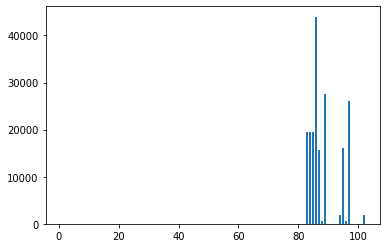

In [ ]:
plt.bar(range(1, len(nas)+1), nas)

(array([94.,  0.,  0.,  2.,  3.,  1.,  1.,  0.,  0.,  1.]),
 array([    0. ,  4398.7,  8797.4, 13196.1, 17594.8, 21993.5, 26392.2,
        30790.9, 35189.6, 39588.3, 43987. ]),
 <a list of 10 Patch objects>)

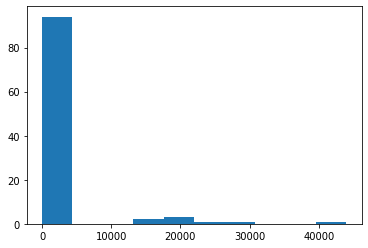

In [ ]:
plt.hist(nas)

In [ ]:
nasCols

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

# Подход 1: градиентный бустинг "в лоб"

## Вопрос 1

Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

### Ответ 

Названия признаков с пропусками перечислены в nasCols (одной ячейкой выше).
Это признаки, связанные с событием "первая кровь", и отметки времени приобретения каждой из команд различных предметов.
Пропуски во второй группе признаков, по-видимому, связаны с тем, что по окончании игры у команды может не быть одного или нескольких из указанных предметов.

In [ ]:
y = features['radiant_win']

In [ ]:
len(y) - y.count() # no Na in dependent var

0

## Вопрос 2

Как называется столбец, содержащий целевую переменную?

### Ответ 

Cтолбец, содержащий целевую переменную, называется radiant_win.
Кстати, там нет пропусков.

## Fill missing values

In [ ]:
X_filled = X.fillna(0)

# Estimate Gradient Boosting, n_estimators=30

In [ ]:
# посмотрим названия всех метрик и найдем AUC-ROC
from sklearn.metrics import SCORERS
print(sorted(SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [ ]:
# замерим время кросс-валидации для n_estimators=30
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
clf = GradientBoostingClassifier(n_estimators=30, verbose=False, random_state=RANDOM_STATE)

start_time = datetime.datetime.now()
cval=cross_val_score(clf, X_filled, y, cv=gen, scoring='roc_auc')
print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:02:56.824821


In [ ]:
print(sum(cval)/len(cval))

0.6894962060591201


## Вопрос 3

Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

### Ответ

Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 02 минуты 56.824821 секунд.

Средний по сплитам кросс-валидации показатель AUC-ROC составил примерно 69%.

# Estimate Gradient Boosting, n_estimators=10,20,30

Time elapsed: 0:06:20.870989


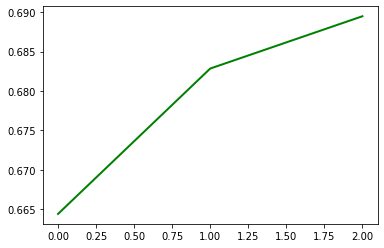

In [ ]:
start_time = datetime.datetime.now()
ne = [10,20,30] # n_estimators
est_loss = []
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for i in range(len(ne)):
    clf = GradientBoostingClassifier(n_estimators=ne[i], verbose=False, random_state=RANDOM_STATE)
    cval=cross_val_score(clf, X_filled, y, cv=gen, scoring='roc_auc')
    cval = sum(cval)/len(cval)
    
    est_loss.append(cval)
print('Time elapsed:', datetime.datetime.now() - start_time)

plt.figure()
plt.plot(est_loss, 'g', linewidth=2)

Time elapsed: 0:10:07.603762


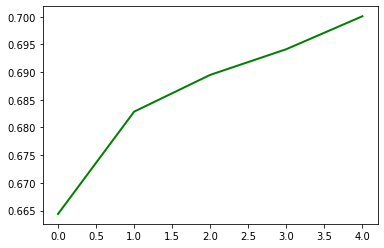

In [ ]:
# проверим n_estimators = 40 и 50
start_time = datetime.datetime.now()
ne = [40,60] # n_estimators
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for i in range(len(ne)):
    clf = GradientBoostingClassifier(n_estimators=ne[i], verbose=False, random_state=RANDOM_STATE)
    cval=cross_val_score(clf, X_filled, y, cv=gen, scoring='roc_auc')
    cval = sum(cval)/len(cval)
    
    est_loss.append(cval)
print('Time elapsed:', datetime.datetime.now() - start_time)

plt.figure()
plt.plot(est_loss, 'g', linewidth=2)

## Ускоряем процесс

### Уменьшаем обучающую выборку с 80% до 50%

In [ ]:
# уменьшим train и замерим время кросс-валидации для n_estimators=30
gen=KFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
clf = GradientBoostingClassifier(n_estimators=30, verbose=False, random_state=RANDOM_STATE)

start_time = datetime.datetime.now()
cval=cross_val_score(clf, X_filled, y, cv=gen, scoring='roc_auc')
print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:40.323922


In [ ]:
sum(cval)/len(cval)

0.6890878546051619

### Упрощаем модель

In [ ]:
# уменьшим max_depth и замерим время кросс-валидации для n_estimators=30
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
clf = GradientBoostingClassifier(n_estimators=30, verbose=False, random_state=RANDOM_STATE, max_depth=2)

start_time = datetime.datetime.now()
cval=cross_val_score(clf, X_filled, y, cv=gen, scoring='roc_auc')
print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:01:51.753632


In [ ]:
sum(cval)/len(cval)

0.6830692110503606

## Вопрос 4

Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

### Ответ 

Судя по графику, имеет смысл увеличить количество деревьев, т.к. на графике виден восходящий тренд (хотя тут всего три точки, маловато для тренда).
Для n_estimators = 40 и 50 тренд сохраняется, AUC-ROC подрос до 70%.
При этом суммарное затраченное время составило чуть больше 10 минут.

Ускорение было проведено двумя способами:

1. уменьшением обучающей выборки с 80% до 50% от общего числа наблюдений.
1. уменьшением макисмальной глубины дерева с 3 до 2

Чтобы можно было сравнить результаты, замерим время кросс-валидации для n_estimators = 30 при каждом способе ускорения.

1. Уменьшение обучающей выборки позволило достичь того же уровня средней AUC-ROC в 69% за 40.32 секунд, что существенно меньше, чем предыдущий результат - 02 минуты 56.82 секунд.

2. Уменьшение макисмальной глубины дерева позволило снизить время кросс-валидации до 1 минуты 51.75 секунд, но средняя AUC-ROC снизилась до 68%.

# Подход 2: логистическая регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV
from numpy import linspace

In [ ]:
X_filled.columns

Index(['start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold',
       'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items',
       ...
       'radiant_ward_sentry_count', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_tpscroll_count', 'dire_boots_count', 'dire_ward_observer_count',
       'dire_ward_sentry_count', 'dire_first_ward_time'],
      dtype='object', length=102)

In [ ]:
scaler = StandardScaler()
scaler.get_feature_names_out(X_filled.columns)
X_filled_scaled = scaler.fit_transform(X_filled)
X_filled_scaled = pd.DataFrame(X_filled_scaled, columns=X_filled.columns)
X_filled_scaled.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,-2.544364,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,0.453467,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,-0.728192,1.50723,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.999319,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,1.606179,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,...,1.416964,-0.538253,-0.571065,-0.947053,-0.490513,-0.311205,-0.785580,-1.312874,-0.905651,-0.53886,-0.56754,-0.131690,0.950987,-0.316231,-0.398260,-0.192406,-0.794164,0.976866,-0.565289,0.278256,-0.849902,1.182703,1.681514,-0.788219,0.378538,-0.029781,0.876751,-0.514555,-1.136970,-0.532046,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-2.540452,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,-0.097431,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.438857,0.59158,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.478969,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-0.816535,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,...,-0.942193,2.506742,-0.571065,1.517711,-1.414707,-1.232681,-1.337375,-1.127777,-1.131068,-0.53886,-0.56754,-0.543653,-1.262018,0.599652,0.531154,1.183531,1.570177,-0.540155,-0.565289,0.278256,-0.287631,1.182703,1.050584,-0.788219,0.912215,-0.029781,-1.525446,-0.514555,-2.869460,-0.532046,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,-2.539231,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,1.402237,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-1.004599,-0.32407,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,-0.785057,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-1.491215,-0.277630,0.427498,1.202532,1.900308,-0.524078,...,-0.829853,-0.538253,-0.571065,-0.125465,-0.736965,0.610270,0.268676,-0.940451,-0.680234,-0.53886,-0.56754,-0.543653,0.828042,-0.316231,0.313323,0.939019,1.682765,-0.540155,-0.565289,-0.543829,1.746117,-0.845521,-0.211277,-0.788219,-0.593027,-0.146503,-1.525446,-0.514555,1.461765,-0.532046,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-2.532622,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-0.678935,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,0.684551,1.50723,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-0.478969,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.356526,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,...,0.068874,-0.538253,-0.571065,-0.536259,1.511906,-1.232681,-0.909825,-1.230361,-1.018359,-0.53886,-0.56754,-0.543653,-1.016129,-1.232114,-1.211497,-1.312717,-1.131927,-0.540155,-0.565289,-0.543829,-0.933645,-0.845521,-1.157673,-0.788219,1.391156,0.262024,-1.525446,-1.549070,-0.270725,-0.532046,-0.987486,-0.594053,0.241615,-0.022021,0.269135,-1.554868,0.5

In [ ]:
X_filled_scaled.shape

(97230, 102)

In [ ]:
# поиск оптимального значения параметра С
start_time = datetime.datetime.now()
clf = GridSearchCV(LogisticRegression(verbose=1, random_state=RANDOM_STATE), cv=5, scoring='roc_auc', param_grid={'C': linspace(0.00001, 1, 50)})
clf.fit(X_filled_scaled, y)
print('Time elapsed:', datetime.datetime.now() - start_time)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Time elapsed: 0:05:47.439747


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


In [ ]:
clf.best_estimator_
# оптимальное значение параметра С составило

LogisticRegression(C=0.020417959183673468, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=241, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
clf.best_score_

0.7154923128257413

In [ ]:
start_time = datetime.datetime.now()
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
clf = LogisticRegression(C=0.02, verbose=0, random_state=RANDOM_STATE)
cval=cross_val_score(clf, X_filled_scaled, y, cv=gen, scoring='roc_auc')
av_cval = sum(cval)/len(cval)
print('Time elapsed:', datetime.datetime.now() - start_time)
print(av_cval)

Time elapsed: 0:00:06.214488
0.7163277538364381


In [ ]:
co = clf.fit(X_filled_scaled, y).coef_[0]
sorted(enumerate(co), key=lambda x: abs(x[1]))

[(42, 0.00013957238834573794),
 (83, 0.0004531228690475332),
 (19, 0.0008095244928168931),
 (27, -0.001025366295067537),
 (18, 0.002083948962008335),
 (26, 0.0024087913490687357),
 (50, 0.002671616595809047),
 (23, -0.00276584908272004),
 (8, -0.003083311103664701),
 (58, -0.003448329224745748),
 (64, 0.0037138400721192554)]

In [ ]:
for i in sorted(enumerate(co), key=lambda x: abs(x[1]))[:30]:
    print(X.columns[i[0]])

# вес большинства категориальных признаков незначителен

d1_hero
first_blood_team
r3_level
r4_level
r3_hero
r4_hero
d2_hero
r3_kills
r1_deaths
d3_hero
d3_deaths
d5_hero
lobby_type
d2_level
r1_hero
d5_kills
r2_kills
first_blood_player1
radiant_ward_sentry_count
d3_kills
d4_hero
r2_level
d1_level
first_blood_time
r4_kills
dire_ward_sentry_count
d4_kills
d2_deaths
r1_kills
radiant_ward_observer_count


## Вопрос 1 

Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?


### Ответ

Качество 71,6%, что немного лучше, чем градиентный бустинг, но различие незначительное.
На самом деле градиентный бустинг дает примерно такой же результат, если увеличить n_estimators.
Таким образом, различия по сути в пределах погрешности.

Логистическая регрессия обучилась намного быстрее при фиксированном параметре С.

## Категориальные признаки

In [ ]:
X.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [ ]:
categorical_features_names = ['lobby_type'] #'hero', 'first_blood_team', 'first_blood_player1', 'first_blood_player2'
X_no_cat_features = X.drop(columns = categorical_features_names)

X_no_cat_features = X_no_cat_features.drop(X_no_cat_features.filter(like='hero').columns, 1)

X_no_cat_features_filled_scaled = X_no_cat_features.fillna(0)
с = StandardScaler().fit_transform(X_no_cat_features_filled_scaled)

In [ ]:
# действительно было удалено 11 признаков
X.shape[1] - X_no_cat_features.shape[1]

11

In [ ]:
start_time = datetime.datetime.now()
clf = GridSearchCV(LogisticRegression(verbose=1, random_state=RANDOM_STATE), cv=5, scoring='roc_auc', param_grid={'C': linspace(0.00001, 1, 50)})
clf.fit(X_no_cat_features_filled_scaled, y)
print('Time elapsed:', datetime.datetime.now() - start_time)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Time elapsed: 0:04:53.333568


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


In [ ]:
clf.best_estimator_
# оптимальное значение параметра С составило

LogisticRegression(C=0.020417959183673468, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=241, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
start_time = datetime.datetime.now()
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
clf = LogisticRegression(C=0.020417959183673468, verbose=1, random_state=RANDOM_STATE)
cval=cross_val_score(clf, X_no_cat_features_filled_scaled, y, cv=gen, scoring='roc_auc')
av_cval = sum(cval)/len(cval)
print('Time elapsed:', datetime.datetime.now() - start_time)
print(av_cval)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:05.959510
0.7163885726914441


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


## Вопрос 2 

Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?



#### Ответ

Удаление категориальных признаков практически не повлияло на среднее значение метрики качества.
Новое округленное значение составило 71,63%.
Отстуствие изменения можно объяснить тем, что вес категориальных признаков был крайне малым, порядка 1е-3.
8 из 10 признаков, содержащих в названии слово hero, находятся среди последних 30 признаков, отсортированных по весу.

## Вопрос 3 

Сколько различных идентификаторов героев существует в данной игре?


In [ ]:
heroes = pd.read_csv(drive_path + '/data/dictionaries/heroes.csv')
len(pd.unique(heroes.name))

112

#### Ответ

Если под идентификатором героя понимать его имя из словаря heroes.csv, то различных идентификаторов 112.

## Мешок слов

In [ ]:
import numpy as np

In [ ]:
# N — количество различных героев в выборке
N = 112
X_pick = np.zeros((X_filled.shape[0], N))

for i, match_id in enumerate(X_filled.index):
    for p in range(5):
        X_pick[i, X_filled.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_filled.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [ ]:
X_heroes = pd.concat([X_no_cat_features_filled_scaled.reset_index(drop=True), pd.DataFrame(X_pick)], axis=1)

start_time = datetime.datetime.now()
gen=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
clf = LogisticRegression(C=0.020417959183673468, verbose=1, random_state=RANDOM_STATE)
cval=cross_val_score(clf, X_heroes, y, cv=gen, scoring='roc_auc')
av_cval = sum(cval)/len(cval)
print('Time elapsed:', datetime.datetime.now() - start_time)
print(av_cval)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed

Time elapsed: 0:00:03.122424
0.5134556409261802


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
X_heroes.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_level,d1_xp,d1_gold,d1_lh,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
0,1430198770,5,2098,1489,20,0,0,7,3,842,991,10,0,0,4,5,1909,1143,10,0,0,8,3,757,741,6,0,0,7,3,732,658,4,0,1,11,3,1058,996,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1430220345,4,1188,1033,9,0,1,12,4,1596,993,10,0,1,7,4,1506,1502,18,1,0,7,3,669,631,7,0,0,7,2,415,539,1,0,0,5,5,1960,1384,16,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1430227081,4,1319,1270,22,0,0,12,3,1314,775,6,0,0,6,3,1297,909,0,1,0,6,5,2360,2096,26,1,1,6,3,1395,1627,27,0,0,9,5,2305,2028,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1430263531,4,1779,1056,14,0,0,5,2,539,539,1,0,0,6,5,2037,1139,15,0,0,6,2,591,499,0,0,0,6,3,712,1075,12,0,0,6,5,1878,1174,17,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1430282290,4,1431,1090,8,1,0,8,2,629,552,0,0,1,7,3,884,927,0,1,0,8,3,925,1439,16,1,0,11,4,1482,880,7,0,0,8,3,704,586,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Вопрос 4 



Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?


### Ответ

Средний ROC-AUC составил 0.51, т. е. качество ухудшилось по сравнению с предыдущим вариантом. 

<BarContainer object of 112 artists>

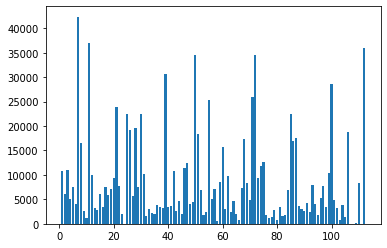

In [ ]:
plt.bar(range(1, N+1), abs(X_pick).sum(axis=0))

In [ ]:
print(np.median(abs(X_pick).sum(axis=0)))
np.median(abs(X_pick).sum(axis=0))/len(X_filled)

5010.0


0.05152730638691762

Возможно, это связано с тем, что в добавленных фичах довольно мало информации - 50% фичей содержат не более 5010 ненулевых значений. Остальные 95% значений - нули. 

## Прогноз

In [ ]:
X_test = features_test.fillna(0)
X_test = X_test.drop(columns=categorical_features_names)
X_test = X_test.drop(X_test.filter(like='hero').columns, 1)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
clf = LogisticRegression(C=0.020417959183673468, verbose=1, random_state=RANDOM_STATE)
clf.fit(X_no_cat_features_filled_scaled, y)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


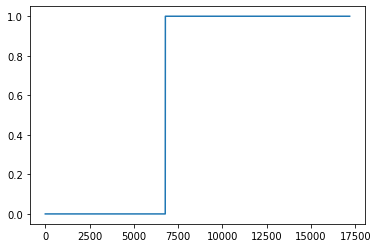

In [ ]:
plt.plot(pred)

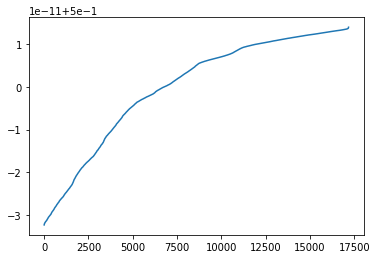

In [ ]:
plt.plot(pred_prob[:,1])

## Вопрос 5 

Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

### Ответ

In [ ]:
print(min(pred_prob[:,1]), max(pred_prob[:,1]))

0.49999999996770517 0.5000000000139433
